In [45]:
import numpy as np
import os,sys
import math
from sklearn.cluster import KMeans
from scipy import spatial
import scipy.stats as sp
import uproot



#--------------------------------------------------------------------------------------------------------------------------------------------

def getData(fname="", procName="Events"):
    file = uproot.open(fname)
    dq_dict = file[procName].arrays(library="np")
    dq_events = {
        "Hits":{
            "detID": dq_dict["hit_detID"],
            "edep": dq_dict["hit_edep"],
            "elmID": dq_dict["hit_elmID"],
            "hit_pos": dq_dict["hit_pos"]
        },
        "track":{
            "x": dq_dict["track_x_CAL"],
            "y": dq_dict["track_y_CAL"],
            "ID": dq_dict["eventID"],
            "pz": dq_dict["track_pz_st1"]
        },
        "st23": {
            "ntrack23": dq_dict["n_st23tracklets"],
            "px":   dq_dict["st23tracklet_px_st3"],
            "py":   dq_dict["st23tracklet_py_st3"],
            "pz":   dq_dict["st23tracklet_pz_st3"],
            "x":   dq_dict["st23tracklet_x_st3"],
            "y":   dq_dict["st23tracklet_y_st3"],
            "z":   dq_dict["st23tracklet_z_st3"],
            "Cal_x": dq_dict["st23tracklet_x_CAL"],
            "Cal_y": dq_dict["st23tracklet_y_CAL"]
        }
    }

    return dq_events
#--------------------------------------------------------------------------------------------------------------------------------------------

ntowersx=72
ntowersy=36
sizex=5.53 # in cm
sizey=5.53 # in cm
ecalx=[-200,200] #size in cm
ecaly=[-100,100]
binsx=ecalx[1]- ecalx[0]
binsy=ecaly[1]- ecaly[0]
sfc = 0.1146337964120158 #sampling fraction of emcal
emin=0.0005
det_z={41: 2130.27, 42: 2146.45, 43:2200.44 , 44:2216.62 , 45:2251.71 , 46: 2234.29}


#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_bytuple(dq_events):
    dq_hits = dq_events["Hits"]
    x_pos = []
    y_pos = []
    eve_energy = []
    for i in range(len(dq_events["Hits"]["edep"])):
        output = emcal_byevent(dq_hits, i)
        if len(output[0]) != 0:
            x_pos.append(output[0])
            y_pos.append(output[1])
            eve_energy.append(output[2])
        else:
            x_pos.append(np.array([]))
            y_pos.append(np.array([]))
            eve_energy.append(np.array([]))
            
    return x_pos, y_pos, eve_energy

#--------------------------------------------------------------------------------------------------------------------------------------------

def emcal_byevent(dq_hits, evtNum):
    raw_elmID = dq_hits["elmID"][evtNum]
    raw_edep = dq_hits["edep"][evtNum]
    
    emcal_mask = dq_hits["detID"][evtNum] == 100
    eng_mask = raw_edep[emcal_mask] >= emin
    
    elmID = raw_elmID[emcal_mask][eng_mask]#could also use dstack here to zip (elmID and edep)
    edep = raw_edep[emcal_mask][eng_mask]
    
    emcal_towerx = elmID // ntowersy
    emcal_towery = elmID % ntowersy
    emcal_x = ecalx[0] + emcal_towerx * sizex
    emcal_y = ecaly[0] + emcal_towery * sizey
    emcal_edep = edep / sfc
    
    return emcal_x, emcal_y, emcal_edep

#--------------------------------------------------------------------------------------------------------------------------------------------

def find_energy_seeds(x, y, energy, min_energy=0.2, seed_radius=50):
    high_energy_mask =energy >min_energy
    high_energy_points = np.column_stack((x[high_energy_mask], y[high_energy_mask], energy[high_energy_mask]))
    seeds = []
    indices = []
    for i, (x_val, y_val, energy_val) in enumerate(high_energy_points):
        distances = np.array(np.sqrt((high_energy_points[:, 0] - x_val)**2 + (high_energy_points[:, 1] - y_val)**2))
        distances[i] = seed_radius + 1
        points_within_radius_mask = distances < seed_radius
        points_within_radius = high_energy_points[points_within_radius_mask]
        if len(points_within_radius) == 0 or energy_val > np.max(points_within_radius[:, 2], initial=0):
            seeds.append([x_val, y_val])
            indices.append(np.where(high_energy_mask)[0][i])
            
    return len(np.array(seeds))

In [8]:
def plot_acceptance(mass, coupling, Nevent, acceptance, hue_norm = (0,1)):
    
    fig, ax = plt.subplots()
    im = ax.scatter(mass, coupling, c=acceptance, s=750, marker='s', cmap='Spectral_r',linewidths=0)

    fig.colorbar(im, ax=ax)

    plt.xlabel(r"$m_{A'}$ [GeV]")
    plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)

    # iterate over axes of FacetGrid
    labels = ax.get_yticks() # get y labels

    new_labels = []
    for i,l in enumerate(labels):
        new_labels.append(r"$10^{%s}$"%labels[i])

    ax.set_yticklabels(new_labels) # set new labels

    plt.show()
    
    
    



In [9]:
Aee_dir = "/Users/wongdowling/Desktop/n-tuples/Aee_500-600"
Amm_dir = "/Users/wongdowling/Desktop/n-tuples/Amm_500-600"

In [10]:
def scan_Aee(scan_dir):
    os.chdir(scan_dir)
    mass = []
    coupling = []
    nseed_trk = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("AeeBrem")& (not filename.endswith("_DST.root")):
            Ap_config = filename[:-5].split('_')
            dq_events = getData(filename, "Events")
            (x, y, eng) = emcal_bytuple(dq_events)
            seed = 0
            for i in range(len(x)):
                seed+= find_energy_seeds(x[i], y[i], eng[i])
            ntrk = sum(dq_events["st23"]["ntrack23"])
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-2]))
            nseed_trk.append(seed/ntrk)
    return mass, coupling, nseed_trk

In [46]:
(a, b, c) = scan_Aee(Aee_dir)

In [47]:
len(a)

443

In [48]:
import matplotlib.pyplot as plt


/var/folders/mf/cqjfz_8x7tgbhvl955fzybtr0000gn/T/ipykernel_6990/3496437151.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


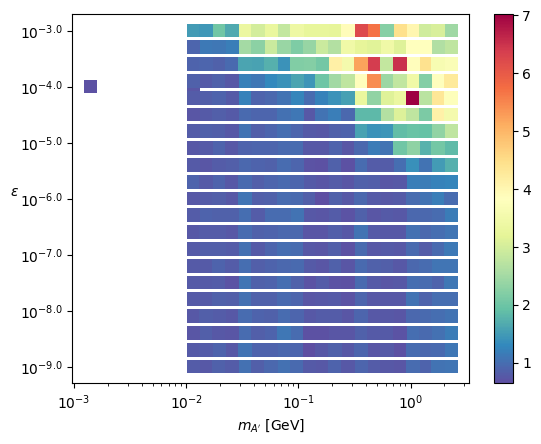

In [49]:
fig, ax = plt.subplots()
im = ax.scatter(a, b, c=c, s=100, marker='s', cmap='Spectral_r',linewidths=0)
fig.colorbar(im, ax=ax)

plt.xlabel(r"$m_{A'}$ [GeV]")
plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)
ax.set_xscale("log")


# iterate over axes of FacetGrid
labels = ax.get_yticks() # get y labels

new_labels = []
for i,l in enumerate(labels):
    new_labels.append(r"$10^{%s}$"%labels[i])

ax.set_yticklabels(new_labels) # set new labels

plt.show()

In [14]:
def scan_Amm(scan_dir):
    os.chdir(scan_dir)
    mass = []
    coupling = []
    nseed_trk = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.startswith("AmmBrem")& (not filename.endswith("_DST.root")):
            Ap_config = filename[:-5].split('_')
            dq_events = getData(filename, "Events")
            (x, y, eng) = emcal_bytuple(dq_events)
            seed = 0
            for i in range(len(x)):
                seed+= find_energy_seeds(x[i], y[i], eng[i])
            ntrk = sum(dq_events["st23"]["ntrack23"])
            mass.append(float(Ap_config[1]))
            coupling.append(float(Ap_config[-2]))
            nseed_trk.append(seed/ntrk)
    return mass, coupling, nseed_trk

In [50]:
(d, e, f) = scan_Amm(Amm_dir)

In [51]:
len(d)

609

/var/folders/mf/cqjfz_8x7tgbhvl955fzybtr0000gn/T/ipykernel_6990/3145746097.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_labels) # set new labels


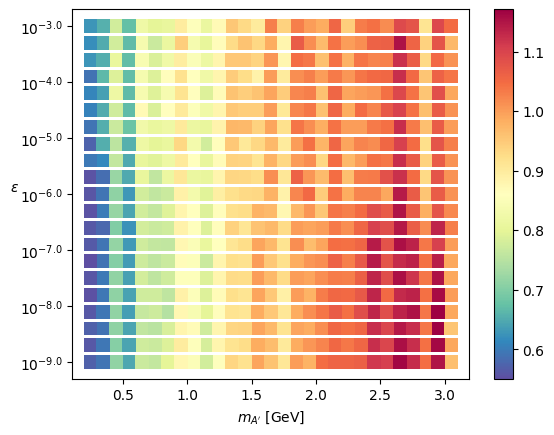

In [52]:
fig, ax = plt.subplots()
im = ax.scatter(d, e, c=f, s=100, marker='s', cmap='Spectral_r',linewidths=0)
fig.colorbar(im, ax=ax)

plt.xlabel(r"$m_{A'}$ [GeV]")
plt.ylabel(ylabel=r"$\epsilon$", rotation = 0)
#ax.set_xscale("log")


# iterate over axes of FacetGrid
labels = ax.get_yticks() # get y labels

new_labels = []
for i,l in enumerate(labels):
    new_labels.append(r"$10^{%s}$"%labels[i])

ax.set_yticklabels(new_labels) # set new labels

plt.show()

In [37]:
def scan_train(scan_dir):
    os.chdir(scan_dir)
    p_type = []
    nseed_trk = []

    #Loop through the files
    for filename in os.listdir(scan_dir):
        if filename.endswith("p580.root"):
            Ap_config = filename[:-5].split('_')
            dq_events = getData(filename, "Events")
            (x, y, eng) = emcal_bytuple(dq_events)
            seed = 0
            for i in range(len(x)):
                seed+= find_energy_seeds(x[i], y[i], eng[i])
            ntrk = sum(dq_events["st23"]["ntrack23"])
            p_type.append(Ap_config[0])
            nseed_trk.append(seed/ntrk)
    return p_type, nseed_trk

In [38]:
os.chdir("/Users/wongdowling/Desktop/n-tuples/5_80_training")
for filename in os.listdir("/Users/wongdowling/Desktop/n-tuples/5_80_training"):
    print(filename)
    Ap_config = filename[:-5].split('_')
    print(Ap_config[0])

.DS_Store
.DS
pi-_520_p580.root
pi-
photon_520_p580.root
photon
pi+_520_p580.root
pi+
positron_520_p580.root
positron
muon_520_p580.root
muon
electron_520_p580.root
electron
klong_520_p580.root
klong
pi0_520_p580.root
pi0


In [40]:
(a, b) = scan_train("/Users/wongdowling/Desktop/n-tuples/5_80_training")

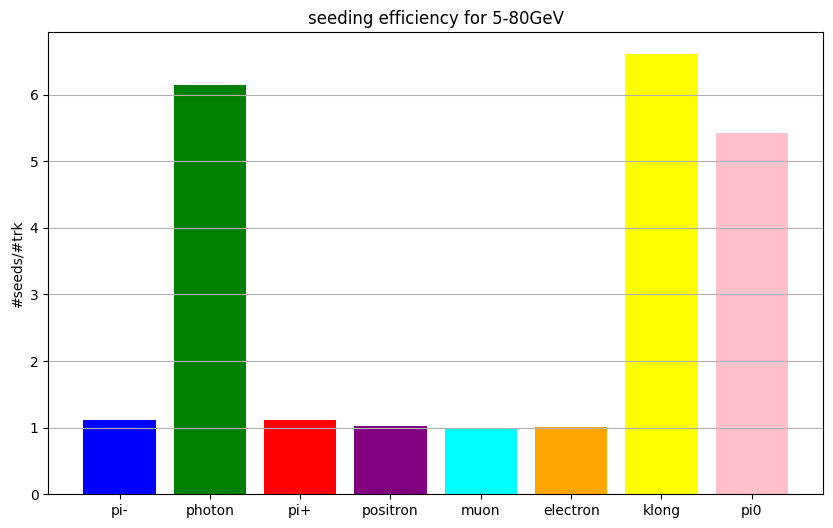

In [44]:

plt.figure(figsize=(10,6))
plt.bar(a, b, color=['blue', 'green', 'red', 'purple', 'cyan', 'orange', 'yellow', 'pink'])
plt.ylabel('#seeds/#trk')
plt.title('seeding efficiency for 5-80GeV')
plt.grid(axis='y')

plt.show()
